In [1]:
#Track feature points and their trajectory 
%run show_image.ipynb
import numpy as np
import cv2

#Track feature points every other frame (2) and trace 5 frames
NUM_FRAMES_TO_TRACK = 5
NUM_FRAMES_JUMP  = 2 

In [2]:
cap = cv2.VideoCapture('Wacci_Video.mp4')
scaling_factor = 1

TRACKING_PARAMS = {"winSize": (11, 11), "maxLevel" : 2, "criteria" : (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)}


In [3]:

tracking_paths = []
frame_index = 0
prev_gray = None

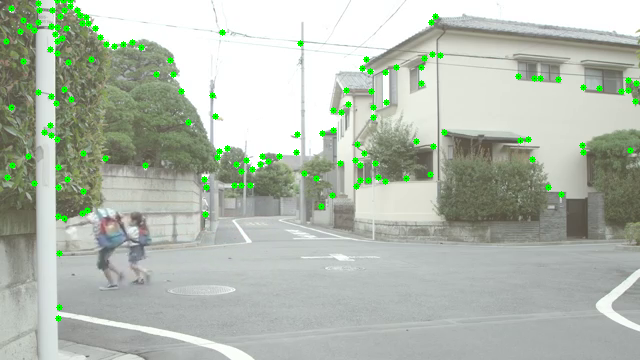

In [4]:
#Use following loop to observe each frame
try: 
    while True:
        #Capture 2 frames to use for comparison
        frame = get_frame(cap, scaling_factor)
        if frame is None: break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        if prev_gray is None:
            prev_gray = frame_gray
            continue
        
        if frame_index%NUM_FRAMES_JUMP == 0:
            mask = np.ones_like(prev_gray)
            for x, y in [tp[-1] for tp in tracking_paths]:
                cv2.circle(mask, (x, y), 6, 0, -1)
            
            feature_points = cv2.goodFeaturesToTrack(prev_gray, mask = mask, maxCorners = 500, qualityLevel = 0.3, minDistance = 7, blockSize = 7)
            
            if feature_points is not None:
                for x, y in feature_points.reshape(-1, 2):
                    tracking_paths.append([(x, y)])
                    
        #Tracks moving feature points            
        if len(tracking_paths) > 0:
            feature_points_0 = np.float32([tp[-1] for tp in tracking_paths]).reshape(-1, 1, 2)
            feature_points_1, _, _ = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, feature_points_0, None, **TRACKING_PARAMS)
            feature_points_0_rev, _, _ = cv2.calcOpticalFlowPyrLK(frame_gray, prev_gray, feature_points_1, None, **TRACKING_PARAMS)
            diff_feature_points = abs(feature_points_0 - feature_points_0_rev).reshape(-1, 2).max(axis = 1)
            good_points = diff_feature_points < 1
            
            new_tracking_paths = []
            
            for tp, (x, y), good_points_flag in \
                zip(tracking_paths, feature_points_1.reshape(-1, 2), good_points):
                if not good_points_flag: continue
                tp.append((x, y))
                if len(tp) > NUM_FRAMES_TO_TRACK:
                    del tp[0]
                
                new_tracking_paths.append(tp)
                cv2.circle(frame, (x, y), 3, (0, 255, 0), -1)
                cv2.polylines(frame, [np.int32(tp)], False, (0, 150, 0))
            tracking_paths = new_tracking_paths
        show_image(frame)
        frame_index += 1
        prev_frame = frame_gray
    
except KeyboardInterrupt:
    print('Interrupted')
cap.release()